In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso

# Data generating process

First, we generate the true coefficients:

In [200]:
np.random.seed(0)

n_predictors = 100

Beta = 2*np.random.random(n_predictors) - 1 # random uniforms: Unif(-1, 1)
Beta[np.where(np.abs(Beta) < 0.9)] = 0. # we zero-out each coefficient with |.| < 0.8
Beta

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.92732552,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.95956321,  0.        ,  0.        ,  0.        ,
        0.95723668,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.9624204 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.97674768,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [201]:
print(f'Number of non-zero coefficients: {(Beta != 0.).sum()} out of 100')

Number of non-zero coefficients: 10 out of 100


Next, we generate the test set, which will be used throughout the analysis:

In [202]:
np.random.seed(0)

n_obs_test = 200
sigma = 3.0

# the matrix of predictors: X
X_test = np.random.normal(0., 1., (n_obs_test, n_predictors))

# the response variable: y
y_test_true = X_test.dot(Beta)
y_test = y_test_true + np.random.normal(0.0, sigma, (n_obs_test, ))

# Penalized regression

First, we define a list of regression penalties ($\lambda$'s):

In [203]:
lambdas = np.logspace(-3, 3, 200)
lambdas

array([1.00000000e-03, 1.07189132e-03, 1.14895100e-03, 1.23155060e-03,
       1.32008840e-03, 1.41499130e-03, 1.51671689e-03, 1.62575567e-03,
       1.74263339e-03, 1.86791360e-03, 2.00220037e-03, 2.14614120e-03,
       2.30043012e-03, 2.46581108e-03, 2.64308149e-03, 2.83309610e-03,
       3.03677112e-03, 3.25508860e-03, 3.48910121e-03, 3.73993730e-03,
       4.00880633e-03, 4.29700470e-03, 4.60592204e-03, 4.93704785e-03,
       5.29197874e-03, 5.67242607e-03, 6.08022426e-03, 6.51733960e-03,
       6.98587975e-03, 7.48810386e-03, 8.02643352e-03, 8.60346442e-03,
       9.22197882e-03, 9.88495905e-03, 1.05956018e-02, 1.13573336e-02,
       1.21738273e-02, 1.30490198e-02, 1.39871310e-02, 1.49926843e-02,
       1.60705282e-02, 1.72258597e-02, 1.84642494e-02, 1.97916687e-02,
       2.12145178e-02, 2.27396575e-02, 2.43744415e-02, 2.61267523e-02,
       2.80050389e-02, 3.00183581e-02, 3.21764175e-02, 3.44896226e-02,
       3.69691271e-02, 3.96268864e-02, 4.24757155e-02, 4.55293507e-02,
      

In [204]:
n_sim = 100
n_obs_train = 300

models = [Ridge, Lasso]

returnDict = {}

for model in models:

    model_str = str(model).split('.')[-1][:-2] # 'Ridge' or 'Lasso' as strings
    returnDict[model_str] = {}

    for l in lambdas:

        returnDict[model_str][l] = {'Variance': None, 'Bias^2': None, 'MSE': None}
        
        y_preds = {}
        for i in range(n_sim):
            
            # generate training data
            X_train = np.random.normal(0.0, 1.0, (n_obs_train, n_predictors))
            y_train = X_train.dot(Beta) + np.random.normal(0.0, sigma, n_obs_train)

            reg = model(alpha=l).fit(X_train, y_train)
            y_pred = reg.predict(X_test)
            y_preds[i] = y_pred


        y_preds = pd.DataFrame(y_preds).values.T
        #  print(f"Shape of y_preds: {y_preds.shape}")
        
        mean_preds = y_preds.mean(axis=0)

        bias2 = np.mean((mean_preds - y_test_true)**2)
        returnDict[model_str][l]['Bias^2'] = bias2
      
        var = np.mean(np.var(y_preds, axis=0))
        returnDict[model_str][l]['Variance'] = var

        mse = np.mean((y_preds - y_test_true.reshape(1, -1))**2)
        returnDict[model_str][l]['MSE'] = mse

Ridge_df = pd.DataFrame(returnDict['Ridge']).T
Lasso_df = pd.DataFrame(returnDict['Lasso']).T

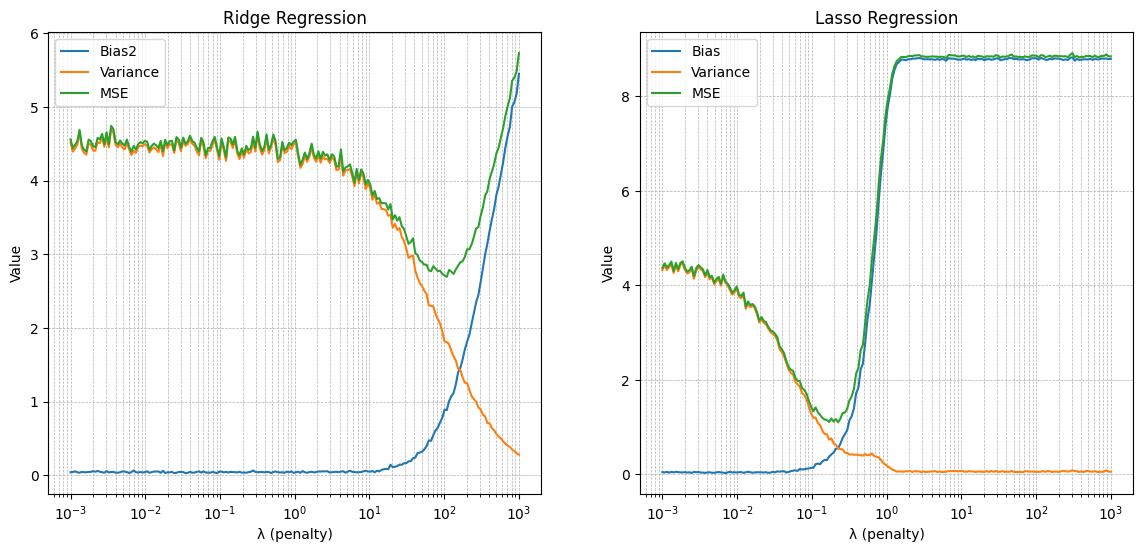

In [205]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Wykres dla Ridge
ax[0].semilogx(Ridge_df.index, Ridge_df['Bias^2'], label='Bias2')
ax[0].semilogx(Ridge_df.index, Ridge_df['Variance'], label='Variance')
ax[0].semilogx(Ridge_df.index, Ridge_df['MSE'], label='MSE')
ax[0].set_xlabel('λ (penalty)')
ax[0].set_ylabel('Value')
ax[0].set_title('Ridge Regression')
ax[0].legend()
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Wykres dla Ridge
ax[1].semilogx(Lasso_df.index, Lasso_df['Bias^2'], label='Bias')
ax[1].semilogx(Lasso_df.index, Lasso_df['Variance'], label='Variance')
ax[1].semilogx(Lasso_df.index, Lasso_df['MSE'], label='MSE')
ax[1].set_xlabel('λ (penalty)')
ax[1].set_ylabel('Value')
ax[1].set_title('Lasso Regression')
ax[1].legend()
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Theoretical background

We can express mean-squared error (MSE) as the sum of three expressions:
$$MSE = \left(f(x) - \mathbb{E}[\hat{f}(x)]\right)^2 + \mathbb{E}\left[\left(\hat{f}(x) - \mathbb{E}[\hat{f}(x)]\right)^2\right] + \sigma^2$$

where $f(x)$ is the function to be approximated by the model, $\hat{f}(x)$ is the model outcome and $\sigma^2$ is the variance of the innovation term $\varepsilon_i$ in the equation $y_i = f(x_i) + \varepsilon_i$.

We now call:
- $Bias = f(x) - \mathbb{E}[\hat{f}(x)]$
- $Variance = \mathbb{E}\left[\left(\hat{f}(x) - \mathbb{E}[\hat{f}(x)]\right)^2\right]$

And thus obtain:
$$MSE = Bias^2 + Variance + \sigma^2$$

There happens to be a tradeoff between bias and variance: more complex model will capture more data, and will thus have lower bias. However, in order to catch more data, variance in predictions has to be larger.

The tradeoff is clearly visible from the plots shown above, with a nice trait that the minimum MSE is where the variance and squared bias intersect, therefore showing the optimal $\lambda$ value to choose. We can also see the expected behaviour that when $\lambda$ increases (simpler model: less non-zero parameters), the bias increases and variance decreases.